In [1]:
#import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob 
import matplotlib.pyplot as plt
import random
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras import models, layers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

Using TensorFlow backend.


In [2]:
## Sort data with [path, id, label]
img_path = glob('/projectnb/cs542sp/idc_classification/data/*/*/*.png', recursive=True)
img_count = len(img_path)
img_name = [""] * img_count
img_label = [""] * img_count

data = pd.DataFrame(img_path, columns=['path'])
def extract_id(x):
    return x.split('/')[-1]
def extract_label(x):
    return x.split("class")[-1].split(".")[0]

data['id'] = data['path'].apply(extract_id)
data['label'] = data['id'].apply(extract_label)
data.head(10)

,path,id,label
0,/projectnb/cs542sp/idc_classification/data/134...,13401_idx5_x1351_y1551_class1.png,1
1,/projectnb/cs542sp/idc_classification/data/134...,13401_idx5_x1751_y1001_class1.png,1
2,/projectnb/cs542sp/idc_classification/data/134...,13401_idx5_x1101_y1601_class1.png,1
3,/projectnb/cs542sp/idc_classification/data/134...,13401_idx5_x1151_y1601_class1.png,1
4,/projectnb/cs542sp/idc_classification/data/134...,13401_idx5_x1351_y1051_class1.png,1
5,/projectnb/cs542sp/idc_classification/data/134...,13401_idx5_x1101_y1651_class1.png,1
6,/projectnb/cs542sp/idc_classification/data/134...,13401_idx5_x1001_y1701_class1.png,1
7,/projectnb/cs542sp/idc_classification/data/134...,13401_idx5_x1551_y851_class1.png,1
8,/projectnb/cs542sp/idc_classification/data/134...,13401_idx5_x1701_y1201_class1.png,1
9,/projectnb/cs542sp/idc_classification/data/134...,13401_idx5_x1301_y1801_class1.png,1


In [3]:
## Read image to np array
def readImage(path):
    bgr_img = cv2.imread(path)
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

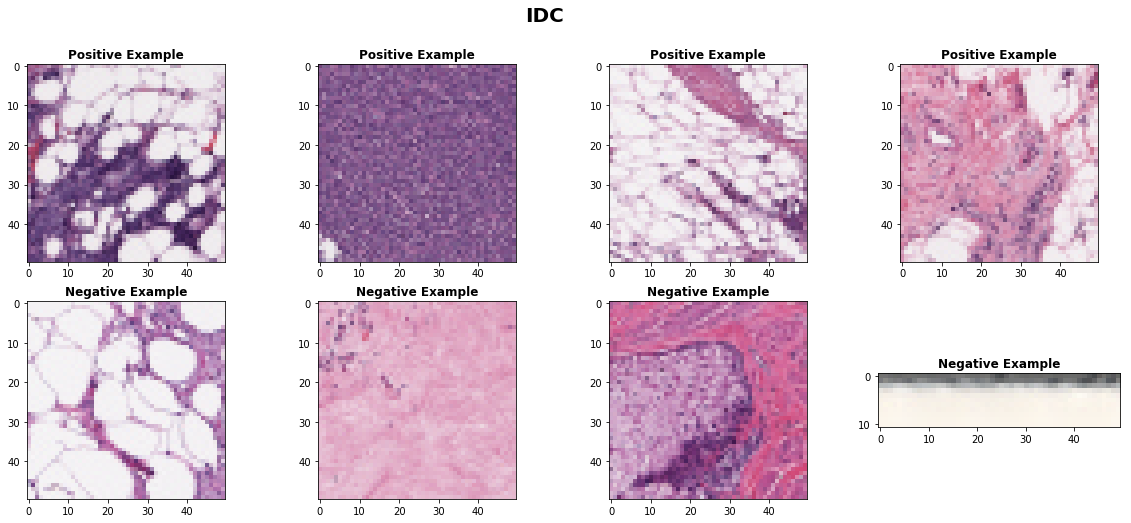

In [4]:
## Visualize some examples
positive_indices = list(np.where(data["label"] == "1")[0])
negative_indices = list(np.where(data["label"] == "0")[0])
rand_pos_inds = random.sample(positive_indices, 4)
rand_neg_inds = random.sample(negative_indices, 4)

fig, ax = plt.subplots(2,4, figsize=(20,8))
fig.suptitle('IDC',fontsize=20, fontweight='bold')

for i in range(0, 4):
    ax[0,i].imshow(readImage(data.iloc[rand_pos_inds[i],0]))
    ax[0,i].set_title("Positive Example", fontweight='bold')
    
    ax[1,i].imshow(readImage(data.iloc[rand_neg_inds[i],0]))
    ax[1,i].set_title("Negative Example", fontweight='bold')

plt.show()
random.shuffle(positive_indices)
random.shuffle(negative_indices)

In [5]:
def describeData():
    print("Total image count : ", len(data))
    print("Positive (idc+) image count :", len(positive_indices))
    print("Negative (idc-) image count :", len(negative_indices))
describeData()

Total image count :  277524
Positive (idc+) image count : 78786
Negative (idc-) image count : 198738


In [6]:
## Oversampling by randomly flip images
def randomFlip(path):
    img = readImage(path)
    mode = random.randint(-1,1)
    return cv2.flip(img, mode)

In [7]:
## Read and oversample all image data
# def procData(lower_ind, upper_ind):
#     x = []
#     y = []
#     for ind in range(lower_ind, upper_ind):
#         path = data['path'][ind]
#         label = data['label'][ind]
#         image = readImage(path)
#         shape = image.shape
#         if shape == (50,50,3):
#             x.append(image)
#             if label == '1':
#                 y.append(1)
#                 x.append(randomFlip(path))
#                 y.append(1)
#             else:
#                 y.append(0)
    
#     return x, y

data = pd.read_pickle("./balancedData_shuffled")
def procData(lower_ind, upper_ind):
    x = []
    y = []
    for ind in range(lower_ind, upper_ind):
        path = data['path'][ind]
        label = data['label'][ind]
        image = data['matrix'][ind]
        shape = image.shape
        if shape == (50,50,3):
            x.append(image)
            if label == '1':
                y.append(1)
            else:
                y.append(0)
    
    return x, y

In [8]:
import math
total = data.shape[0]
test_part = math.ceil(total / 5)
train_part = total - test_part

In [9]:
## Read 10000 images
X,Y = procData(0, train_part)
test_X, test_Y = procData(train_part, total)
print("idc(+) :", Y.count(1))
print("idc(-) :", Y.count(0))
print("Testing size :", len(test_Y))
print("Training data shape :", X[0].shape)
df = pd.DataFrame()
df["images"]=X
df["labels"]=Y
df[0:10]

idc(+) : 126135
idc(-) : 157090
Testing size : 70765
Training data shape : (50, 50, 3)


,images,labels
0,"[[[236, 200, 213], [239, 191, 205], [237, 168,...",0
1,"[[[244, 243, 243], [244, 243, 243], [244, 243,...",0
2,"[[[209, 164, 190], [214, 163, 195], [205, 138,...",0
3,"[[[236, 217, 222], [222, 201, 216], [241, 234,...",1
4,"[[[191, 128, 164], [171, 128, 160], [193, 117,...",0
5,"[[[161, 120, 164], [163, 123, 169], [165, 129,...",0
6,"[[[205, 109, 140], [156, 91, 137], [159, 94, 1...",0
7,"[[[249, 235, 239], [239, 238, 237], [230, 215,...",0
8,"[[[86, 50, 111], [98, 64, 121], [213, 202, 211...",1
9,"[[[183, 134, 168], [209, 141, 173], [209, 146,...",0


In [10]:
# Label processing
y_train = []
y_test = []
for i in Y:
    if i == 0:
        y_train.append(np.array([1,0]))
    elif i == 1:
        y_train.append(np.array([0,1]))

for j in test_Y:
    if i == 0:
        y_test.append(np.array([1,0]))
    elif i == 1:
        y_test.append(np.array([0,1]))
        
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [18]:
## Define model
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop
from keras.callbacks import EarlyStopping
from densenet121 import DenseNet

x_train = np.asarray(X) / 255.0
x_test = np.asarray(test_X) / 255.0
# y_train = np.asarray(Y)
# y_test = np.asarray(test_Y)

model = DenseNet(reduction=0.5, classes=2)

# weight_path="{}_weights.best.hdf5".format('model')
# sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
# earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=16, verbose=0, mode='auto')
# checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=True)
# tensorboard = TensorBoard(log_dir="./logs/{}".format(time()))

model.load_weights('densenet_weights.h5')

model.summary()

/projectnb/cs542sp/idc_classification/densenet121.py:45: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (7, 7), name="conv1", strides=(2, 2), use_bias=False)`
  x = Convolution2D(nb_filter, 7, 7, subsample=(2, 2), name='conv1', bias=False)(x)
/projectnb/cs542sp/idc_classification/densenet121.py:99: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), name="conv2_1_x1", use_bias=False)`
  x = Convolution2D(inter_channel, 1, 1, name=conv_name_base+'_x1', bias=False)(x)
/projectnb/cs542sp/idc_classification/densenet121.py:109: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), name="conv2_1_x2", use_bias=False)`
  x = Convolution2D(nb_filter, 3, 3, name=conv_name_base+'_x2', bias=False)(x)
/projectnb/cs542sp/idc_classification/densenet121.py:165: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  conc

/projectnb/cs542sp/idc_classification/densenet121.py:99: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), name="conv3_10_x1", use_bias=False)`
  x = Convolution2D(inter_channel, 1, 1, name=conv_name_base+'_x1', bias=False)(x)
/projectnb/cs542sp/idc_classification/densenet121.py:109: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), name="conv3_10_x2", use_bias=False)`
  x = Convolution2D(nb_filter, 3, 3, name=conv_name_base+'_x2', bias=False)(x)
/projectnb/cs542sp/idc_classification/densenet121.py:99: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), name="conv3_11_x1", use_bias=False)`
  x = Convolution2D(inter_channel, 1, 1, name=conv_name_base+'_x1', bias=False)(x)
/projectnb/cs542sp/idc_classification/densenet121.py:109: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), name="conv3_11_x2", use_bias=False)`
  x = Convolution2D(nb_filter, 3, 3, name=conv_name_base+'_

/projectnb/cs542sp/idc_classification/densenet121.py:99: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), name="conv4_14_x1", use_bias=False)`
  x = Convolution2D(inter_channel, 1, 1, name=conv_name_base+'_x1', bias=False)(x)
/projectnb/cs542sp/idc_classification/densenet121.py:109: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), name="conv4_14_x2", use_bias=False)`
  x = Convolution2D(nb_filter, 3, 3, name=conv_name_base+'_x2', bias=False)(x)
/projectnb/cs542sp/idc_classification/densenet121.py:99: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), name="conv4_15_x1", use_bias=False)`
  x = Convolution2D(inter_channel, 1, 1, name=conv_name_base+'_x1', bias=False)(x)
/projectnb/cs542sp/idc_classification/densenet121.py:109: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), name="conv4_15_x2", use_bias=False)`
  x = Convolution2D(nb_filter, 3, 3, name=conv_name_base+'_

/projectnb/cs542sp/idc_classification/densenet121.py:99: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), name="conv5_6_x1", use_bias=False)`
  x = Convolution2D(inter_channel, 1, 1, name=conv_name_base+'_x1', bias=False)(x)
/projectnb/cs542sp/idc_classification/densenet121.py:109: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), name="conv5_6_x2", use_bias=False)`
  x = Convolution2D(nb_filter, 3, 3, name=conv_name_base+'_x2', bias=False)(x)
/projectnb/cs542sp/idc_classification/densenet121.py:99: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), name="conv5_7_x1", use_bias=False)`
  x = Convolution2D(inter_channel, 1, 1, name=conv_name_base+'_x1', bias=False)(x)
/projectnb/cs542sp/idc_classification/densenet121.py:109: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), name="conv5_7_x2", use_bias=False)`
  x = Convolution2D(nb_filter, 3, 3, name=conv_name_base+'_x2',

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
data (InputLayer)                (None, 50, 50, 3)     0                                            
____________________________________________________________________________________________________
conv1_zeropadding (ZeroPadding2D (None, 56, 56, 3)     0           data[0][0]                       
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 25, 25, 64)    9408        conv1_zeropadding[0][0]          
____________________________________________________________________________________________________
conv1_bn (BatchNormalization)    (None, 25, 25, 64)    256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
pred = model.predict(x_test)
y_test = test_Y
tp = 0
fp = 0
tn = 0
fn = 0
for i in range(len(y_test)):
    if pred[i][0] > pred[i][1]:
        y_pred = 0
    else:
        y_pred = 1
    
    if (y_pred == 1) and (y_test[i] == 1):
        tp = tp + 1
    elif (y_pred == 1) and (y_test[i] == 0):
        fp = fp + 1
    elif (y_pred == 0) and (y_test[i] == 0):
        tn = tn + 1
    elif (y_pred == 0) and (y_test[i] == 1):
        fn = fn + 1


acc = (tp + tn) / (tp + fp + tn + fn)
acc

In [14]:
pred

array([[  9.98414755e-01,   1.58520276e-03],
       [  2.17452552e-02,   9.78254795e-01],
       [  8.20678234e-01,   1.79321766e-01],
       [  8.57843339e-01,   1.42156616e-01],
       [  1.15653224e-01,   8.84346724e-01],
       [  6.77160740e-01,   3.22839171e-01],
       [  4.99866195e-02,   9.50013399e-01],
       [  2.86322176e-01,   7.13677764e-01],
       [  5.09425513e-02,   9.49057460e-01],
       [  1.64719060e-01,   8.35280955e-01],
       [  9.43455696e-01,   5.65442927e-02],
       [  1.35178238e-01,   8.64821732e-01],
       [  9.92900968e-01,   7.09904963e-03],
       [  1.12341918e-01,   8.87658000e-01],
       [  9.93372798e-01,   6.62719179e-03],
       [  6.73875958e-02,   9.32612419e-01],
       [  9.97546971e-01,   2.45305966e-03],
       [  4.68086690e-01,   5.31913280e-01],
       [  6.62701428e-02,   9.33729887e-01],
       [  9.74964380e-01,   2.50356682e-02],
       [  4.73906212e-02,   9.52609420e-01],
       [  8.45152199e-01,   1.54847801e-01],
       [  

In [ ]:
# hist = model.fit(x_train, y_train, batch_size=32, epochs=10, callbacks = [earlystopping, tensorboard], validation_split = 0.2)
# test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=32) # original basize 32

In [ ]:
# # Plot training & validation accuracy values

# plt.plot(hist.history['acc'])
# plt.plot(hist.history['val_acc'])
# plt.title('Model accuracy , ' + str(test_acc))
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(hist.history['loss'])
# plt.plot(hist.history['val_loss'])
# plt.title('Model loss , ' + str(test_loss))
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()